# TeachSpin Muon Lifetime Analysis
In [TeachSpin's Muon Lifetime Experiment](http://www.teachspin.com/muon-physics.html), a data file is produced that contains information about muon decays. It is a two-column tab-delimited text file. According to the TeachSpin manual,

The first field is an encoded positive integer that is either the number of nanoseconds between successive signals that triggered the readout electronics, or the number of “timeouts” in the one-second interval identified by the corresponding data in the second column. An integer less than 40000 is the time, measured in nanoseconds, between successive signals and, background aside, identifies a muon decay. Only data of this type is entered automatically into the decay time histogram.
    
An integer greater than or equal to 40000 corresponds to the situation where the time between successive signals exceeded the timing circuit’s maximum number of 1101 clock cycles or 22020 ns. A non-zero number in the units place indicates the number of times this ‘timeout” situation occurred in the particular second identified by the data in the first field. For example, the integer 40005 in the first field indicates that the readout circuit was triggered 5 times in a particular second but that each time the timing circuit reached its maximum number of clock cycles before the next signal arrived.

The second field is the number of seconds, as measured by the PC, from the beginning of 1 January 1970 (i.e., 00:00:00 1970-01-01 UTC), a date conventional in computer programming.   
    
## The Analysis

The file [muon-data.txt](muon-data.txt) has decay measurements for more than 2500 decays. Read the file, find the rows that correspond to a muon decay, and create a histogram of counts vs. decay times in $\mu s$. Do an exponential curve fit and determine the lifetime of the muon.

Here's a [nice tutorial](https://bespokeblog.wordpress.com/2011/07/11/basic-data-plotting-with-matplotlib-part-3-histograms/) on plotting histograms.

In [0]:
import pandas as pd
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import numpy as np
#from numpy import *
%matplotlib inline
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
plt.style.use('ggplot')

## Load the data from a URL
This probably needs to be modified to load from Github or Google Drive, but here is a way to load data from a webserver. We'll load the data into `df1` using pandas dataframes. The file is space separated. So, we use a delimiter equal to space. It is two columns of time in microseconds and time as a date since 1/1/1970. We'll pull out only the real events (realdata) in the first column and convert them to floating point numbers. Then, reindex them starting from zero.

In [0]:
url = 'https://physics.berea.edu/documents/messina/HEA/muon-data.txt'
df1 = pd.read_csv(url, delimiter=' ')
# Dataset is now stored in a Pandas Dataframe
df1.columns=['raw', 'date']
df1['raw'] = df1['raw'].astype(float)
realdata = df1['raw'][df1['raw'] < 40000]/1000
realdata.reset_index(inplace=True, drop=True)
print(realdata)

0       11.32
1        0.94
2        1.74
3        2.22
4        0.72
        ...  
2586     0.80
2587    17.56
2588     2.06
2589     7.18
2590     2.08
Name: raw, Length: 2591, dtype: float64


## Upload a file from your computer
The following two code cells work for uploading data from your computer into your colab notebook. You will need to modify the file name according to your actual file name.

In [37]:
from google.colab import files
uploaded = files.upload()

Saving muon-data.txt to muon-data.txt


In [38]:
import io
test_df = pd.read_csv(io.BytesIO(uploaded['muon-data.txt']))
print (test_df)

        40000 1442345515
0       40000 1442345516
1       40007 1442345517
2       40002 1442345518
3       40004 1442345519
4       40005 1442345520
...                  ...
239194  40000 1442583193
239195  40000 1442583194
239196  40000 1442583195
239197  40000 1442583196
239198  40000 1442583197

[239199 rows x 1 columns]


Let's plot the raw data, which is the lifetime measured for each event that was detected.

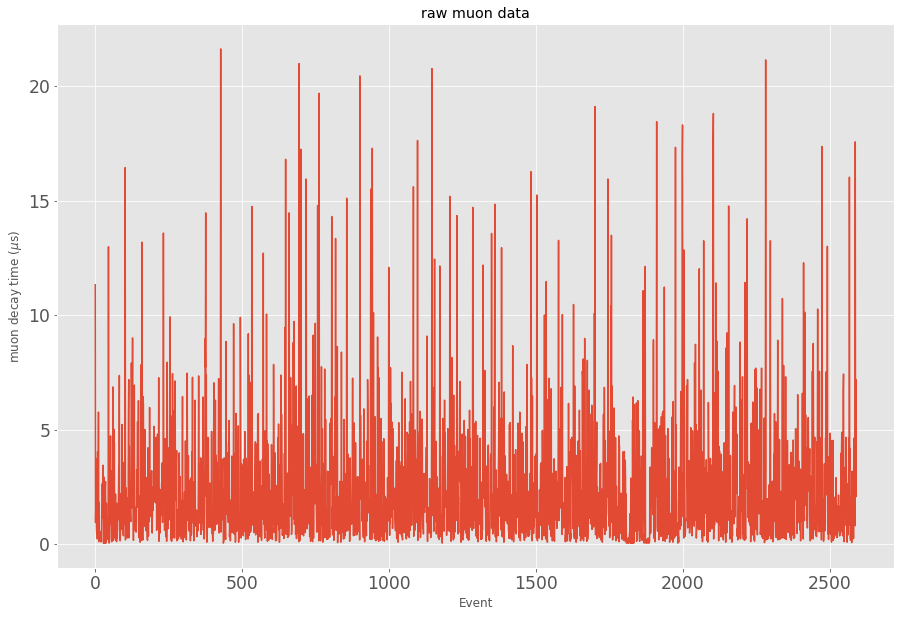

In [0]:
plt.title('raw muon data')
plt.xlabel('Event')
plt.ylabel('muon decay time ($\mu$s)')
plt.plot(realdata)
plt.show()

## Histogram
To see the lifetime as a decay function, we need to make a histogram of the lifetimes. Let's use the power of matplotlib to do this for us. We'll try 25 bins and see how it looks.

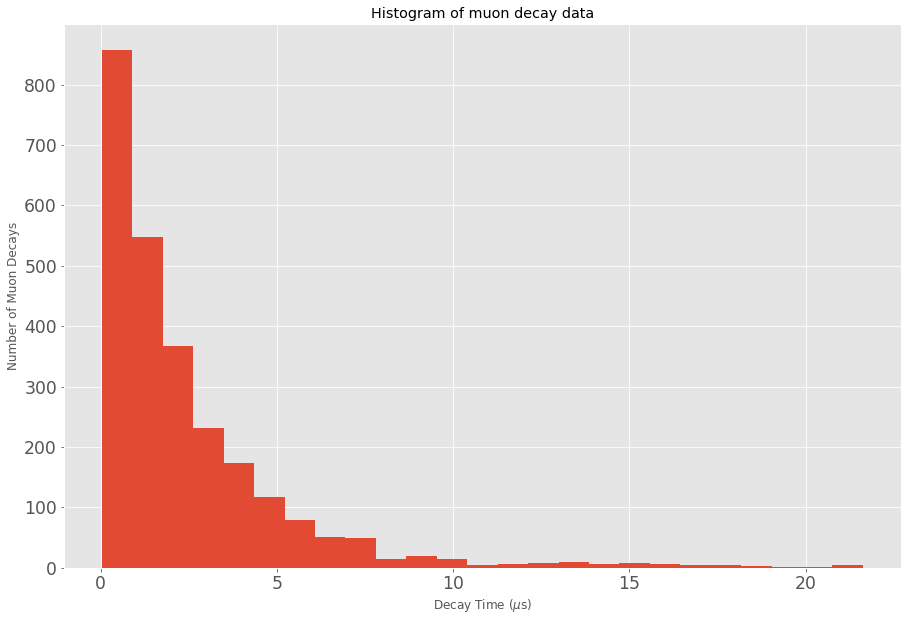

In [0]:
plt.title('Histogram of muon decay data')
plt.xlabel('Decay Time ($\mu$s)')
plt.ylabel('Number of Muon Decays')
plt.hist(realdata, bins=25)
plt.show()

### More bins?

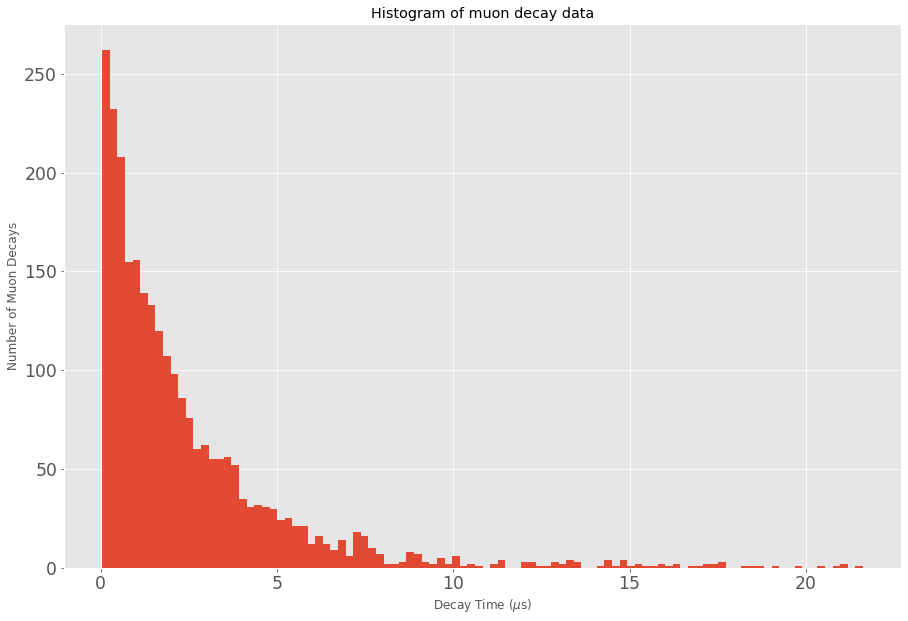

In [0]:
plt.title('Histogram of muon decay data')
plt.xlabel('Decay Time ($\mu$s)')
plt.ylabel('Number of Muon Decays')
plt.hist(realdata, bins=100)
plt.show()

## Normalization
The data as a histogram tells us about the probability of decaying at a particular time. This is because we are seeing how many decays occur during each time bin. We could normalize the distribution (histogram) so that its sum gives us 100% probability.

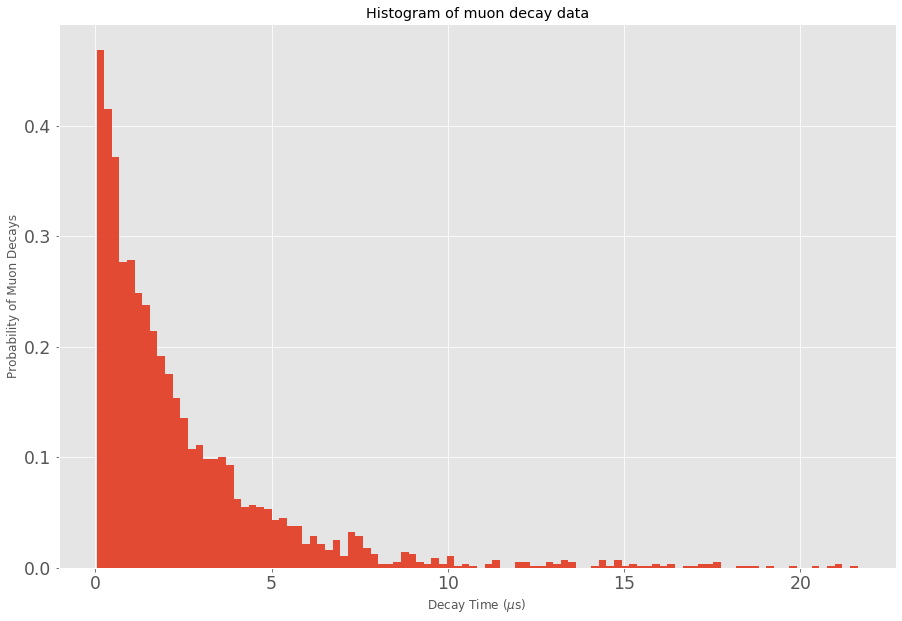

In [0]:
plt.title('Histogram of muon decay data')
plt.xlabel('Decay Time ($\mu$s)')
plt.ylabel('Probability of Muon Decays')
plt.hist(realdata, bins=100, density=True)
plt.show()

## Least Squares fitting
Now, let's do a least squares fit to find the lifetime. We expect the data to be modeled by the function
$$y(t) = A e^{-kt}$$
where $A$ is an arbitrary amplitude that depends on how many muons we detect and $k$ is the rate of decay (units of decays per microsecond). We could also write the function as
$$y(t) = A e^{-t/\tau}$$
where $\tau$ is the lifetime of the muon.

First, we need to make the histogram data an actual array in memory.

100
100


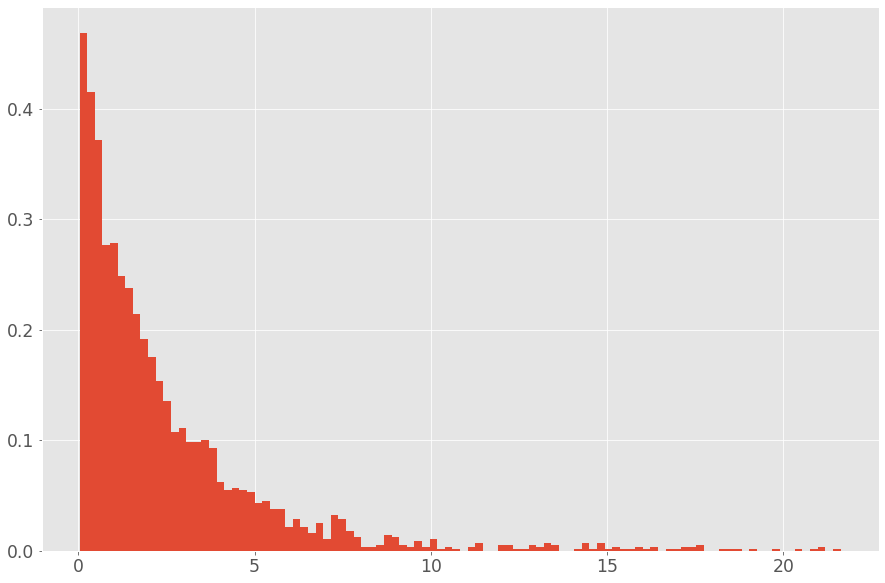

In [0]:
x0 = [0.5, 2] # initial guesses
nbins = 100

hist_y, hist_x, junk = plt.hist(realdata, bins=nbins, density=True) # create a data array
sigma = np.sqrt(hist_y+1)

hist_x = hist_x[0:nbins]
sigma=asarray(sigma)
hist_x = asarray(hist_x)
hist_y = asarray(hist_y)
print(len(hist_x))
print(len(hist_y))

In [0]:
def expfit(x, a, t):
    return a*exp(-x/t)
result = optimization.curve_fit(expfit, hist_x, hist_y, x0, sigma)
print(result)

(array([0.4503403 , 2.07397635]), array([[ 2.73047222e-05, -1.19204246e-04],
       [-1.19204246e-04,  1.06890883e-03]]))


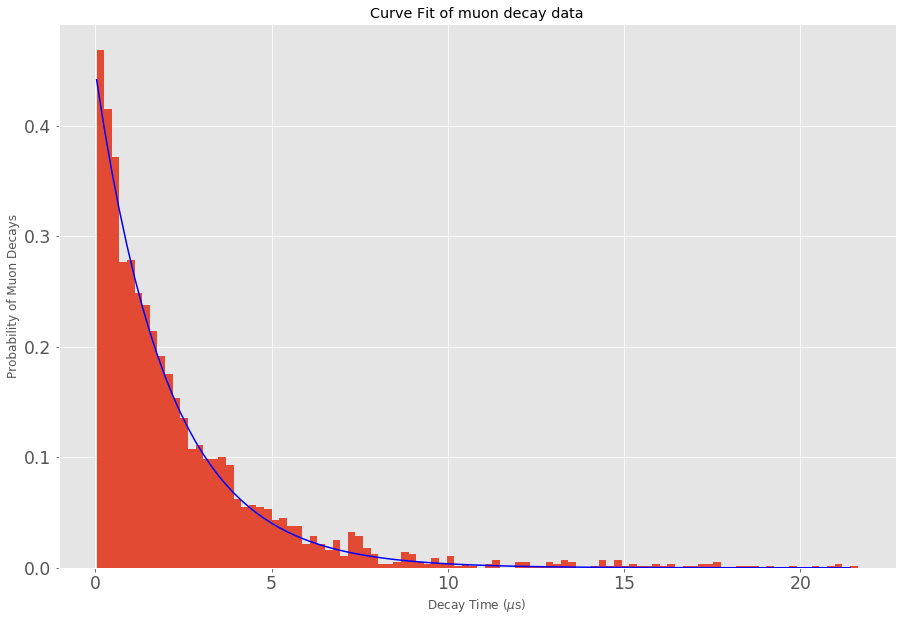

In [0]:
y=result[0][0]*exp(-array(hist_x)/result[0][1]) #y=a*exp(-bx) is the best-fit function
plt.title('Curve Fit of muon decay data')
plt.xlabel('Decay Time ($\mu$s)')
plt.ylabel('Probability of Muon Decays')
plt.hist(realdata, bins=nbins, density=True)
plt.plot(hist_x, y, '-b')
plt.show()